# USER REFERRAL PROGRAM

### Q1: IMPACT OF USER REFERRAL PROGRAM ON THE SITE? ANALYZE REVENUE PER VISOTOR FROM REFERRAL VS. NON-REFERRAL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# SQL SOLUTIONS

SELECT * FROM takehome_challenges.referral;
SELECT MIN(date), MAX(date) FROM takehome_challenges.referral;
SELECT COUNT(*), COUNT(user_id), COUNT(date), COUNT(country), COUNT(money_spent), COUNT(is_referral), COUNT(device_id),
	COUNT(DISTINCT user_id), COUNT(DISTINCT is_referral), COUNT(DISTINCT device_id)
FROM takehome_challenges.referral;
-- total of 97341 records, with 18809 unique users and 17887 unique devices. 

-- total purchases from referral vs non-referral 
SELECT is_referral, COUNT(DISTINCT user_id) AS users, SUM(money_spent) AS total_revenue
FROM takehome_challenges.referral
GROUP BY 1;
-- is_referral, users, total_revenue
-- 0	11951	3034612
-- 1	12715	1315787

-- purchase by country 
SELECT COUNT(DISTINCT country) FROM takehome_challenges.referral;
-- a total of 9 unique countries
WITH temp AS(
SELECT country, 
	COUNT(DISTINCT CASE WHEN is_referral = 0 THEN user_id ELSE NULL END) AS non_referred_users,
    COUNT(DISTINCT CASE WHEN is_referral = 1 THEN user_id ELSE NULL END) AS referred_users,
    SUM(CASE WHEN is_referral = 0 THEN money_spent ELSE NULL END) AS non_referred_revenue,
    SUM(CASE WHEN is_referral = 1 THEN money_spent ELSE NULL END) AS referred_revenue
FROM takehome_challenges.referral
GROUP BY 1
ORDER BY 1)
SELECT SUM(non_referred_users),
	SUM(referred_users),
    SUM(non_referred_revenue),
    SUM(referred_revenue)
FROM temp;
-- non_referred_users, referred_users, non_referred_revenue, referred_revenue
-- 40038	24856	3034612	1315787

SELECT COUNT(DISTINCT user_id) FROM takehome_challenges.referral;
-- 18809

SELECT is_referral, COUNT(DISTINCT user_id) FROM takehome_challenges.referral
GROUP BY 1;
-- 0	11951
-- 1	12715
-- there are overlaps in user_id between referral and non-referral groups

SELECT SUM(users) FROM 
(
SELECT country, COUNT(DISTINCT user_id) AS users
FROM takehome_challenges.referral
GROUP BY 1) temp;
-- 62989
-- there are overlaps in user_id in different countries

-- investigate for each unique user, how many country attributes, how many device attributes, and how many is_referral attributes
SELECT * FROM takehome_challenges.referral
WHERE user_id = 
(
SELECT user_id
FROM takehome_challenges.referral
GROUP BY 1
HAVING COUNT(DISTINCT is_referral) > 1
AND COUNT(DISTINCT country) > 1
AND COUNT(DISTINCT device_id) > 1
LIMIT 1
);
-- confirm the previous finding, i.e. one user can have been in different countries, using different devices, and can be either from referral or not

-- daily number of users and purchase in both groups 
SELECT date, 
	COUNT(DISTINCT CASE WHEN is_referral = 0 THEN user_id ELSE NULL END) AS non_referred_users,
    COUNT(DISTINCT CASE WHEN is_referral = 1 THEN user_id ELSE NULL END) AS referred_users,
    SUM(CASE WHEN is_referral = 0 THEN money_spent ELSE NULL END) AS non_referred_purchases,
    SUM(CASE WHEN is_referral = 1 THEN money_spent ELSE NULL END) AS referred_purchases
FROM takehome_challenges.referral
GROUP BY 1
ORDER BY 1;
-- referral program starts on 2015-10-31?

SELECT is_referral, MIN(date), MAX(date) FROM takehome_challenges.referral
GROUP BY 1;
-- is_referral, MIN(date), MAX(date)
-- 0	2015-10-03	2015-11-27
-- 1	2015-10-31	2015-11-27

-- daily number of users and purchase in both groups by day of week
SELECT 
	WEEKDAY(date),
    DAYNAME(date), 
	COUNT(DISTINCT CASE WHEN is_referral = 0 THEN user_id ELSE NULL END) AS non_referred_users,
    COUNT(DISTINCT CASE WHEN is_referral = 1 THEN user_id ELSE NULL END) AS referred_users,
    SUM(CASE WHEN is_referral = 0 THEN money_spent ELSE NULL END) AS non_referred_purchases,
    SUM(CASE WHEN is_referral = 1 THEN money_spent ELSE NULL END) AS referred_purchases
FROM takehome_challenges.referral
GROUP BY 1,2
ORDER BY 1;

In [ ]:
-- What's the unit of diversion? How do we separate referral vs. non-referral?

SELECT COUNT(*) AS total_transactions, 
	COUNT(DISTINCT user_id) AS unique_users, 
    COUNT(DISTINCT device_id) AS unique_devices,
	COUNT(DISTINCT CASE WHEN is_referral = 1 THEN user_id ELSE NULL END) AS unique_users_referral,
    COUNT(DISTINCT CASE WHEN is_referral = 0 THEN user_id ELSE NULL END) AS unique_users_nonreferral
FROM takehome_challenges.referral;

-- 97341	18809	17887	12715	11951
-- We can see that unit of diversion is transaction, not users, because there are overlap between referral 
-- and non-referral users



-- How many users only had referral transactions, how many only non-referral transactions, how many had both?

SELECT 
	COUNT(CASE WHEN r_user_id IS NULL AND n_user_id IS NOT NULL THEN n_user_id END) AS users_nonreferral,
	COUNT(CASE WHEN r_user_id IS NOT NULL AND n_user_id IS NULL THEN r_user_id END) AS users_referral,
    COUNT(CASE WHEN r_user_id IS NOT NULL AND n_user_id IS NOT NULL THEN r_user_id END) AS users_both
FROM 
(
SELECT r.user_id AS r_user_id, n.user_id AS n_user_id 
FROM 
(SELECT DISTINCT user_id FROM takehome_challenges.referral WHERE is_referral = 1) r
LEFT JOIN 
(SELECT DISTINCT user_id FROM takehome_challenges.referral WHERE is_referral = 0) n 
ON r.user_id = n.user_id
UNION
SELECT r.user_id AS r_user_id, n.user_id AS n_user_id  
FROM
(SELECT DISTINCT user_id FROM takehome_challenges.referral WHERE is_referral = 1) r
RIGHT JOIN 
(SELECT DISTINCT user_id FROM takehome_challenges.referral WHERE is_referral = 0) n 
ON r.user_id = n.user_id
) temp;

-- 6094	6858	5857


In [2]:
referral = pd.read_csv('referral.csv')
referral.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [8]:
# segment users into groups and calculate conversion rate, also add another level of index: control vs treatment
def conversion_segments_ABtest(df, seg_col, test_col, conv_col):
    table = pd.pivot_table(df, values=conv_col, index=seg_col, columns=test_col, 
                           aggfunc=np.mean).rename_axis(None, axis=1).rename_axis(None, axis=0)
    table.plot(kind='bar')
    return table

# segment users into groups and calculate conversion rate, no split b/t control vs treatment
def conversion_segments(df, seg_col, conv_col):
    table = pd.pivot_table(df, values=conv_col, index=seg_col, 
                           aggfunc=np.mean).rename_axis(None, axis=1).rename_axis(None, axis=0)
    table.plot(kind='bar')
    return table

# calculate total user count and conversion rate for each segments 
def count_and_rate(df, seg_col, conv_col):
    t1 = df[[seg_col, conv_col]].groupby(seg_col).count().reset_index()
    t2 = df[[seg_col, conv_col]].groupby(seg_col).mean().reset_index()
    t3 = pd.merge(t1, t2, on=seg_col)
    t3.columns = [seg_col, 'count', 'rate']
    return t3            

def count_and_rate_plot(count_and_rate_table):
    sns.set(font_scale=1.2, palette='Set2')
    cols = count_and_rate_table.columns
    fig = plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(1,2,1)
    count_and_rate_table.plot(kind='bar', x=cols[0], y=cols[1], ax=ax1, legend=None)
    plt.xticks(rotation=45, fontsize=15, ha='center')
    plt.ylabel('Total count', fontsize=20)
    plt.xlabel(cols[0], fontsize=20)

    ax2 = fig.add_subplot(1,2,2)
    count_and_rate_table.plot(kind='bar', x=cols[0], y=cols[2], ax=ax2, legend=None)
    plt.xticks(rotation=45, fontsize=15, ha='center')
    plt.ylabel('Conversion rate', fontsize=20)
    plt.xlabel(cols[0], fontsize=20)
    return

# histogram for continuous variable, split by a target column
#kws={"histtype": "bar", "alpha": 0.3}
kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

def histplot(df, var_col, tar_col, binsize=20, yscale='linear'):
    tar_vals = df[tar_col].value_counts().index
    for tar_val in tar_vals:
        sns.distplot(df.loc[df[tar_col]==tar_val, var_col], bins=binsize, hist_kws=kws, kde=True, norm_hist=True, label=str(tar_val))
    plt.yscale(yscale)
    plt.ylabel('frequency',  fontsize=15)
    plt.xlabel(var_col, fontsize=15)
    plt.legend(fontsize=15)
    return 


,0,1
CA,44.335881,48.820032
CH,57.971579,59.544803
DE,43.907457,49.072149
ES,43.135766,44.634879
FR,43.272727,44.608045
IT,43.263098,44.511167
MX,40.618520,42.939346
UK,44.362494,49.630776
US,44.349394,49.742201


<Figure size 864x288 with 0 Axes>

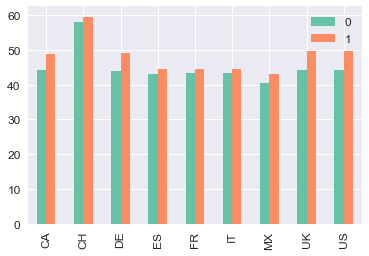

In [10]:
sns.set(font_scale=1.2, palette='Set2')
fig = plt.figure(figsize=(12,4))
conversion_segments_ABtest(referral, 'country', 'is_referral', 'money_spent')

C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


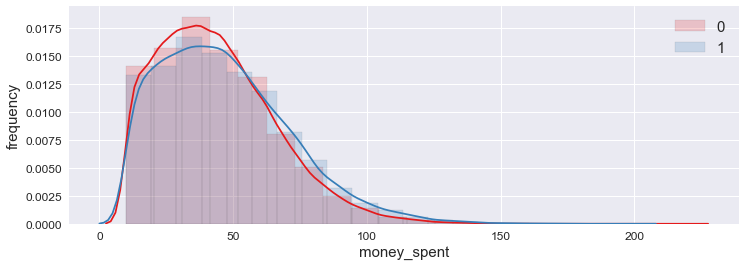

In [9]:
sns.set(font_scale=1.2, palette='Set1')
fig = plt.figure(figsize=(12,4))
histplot(referral, 'money_spent', 'is_referral', binsize=20, yscale='linear')

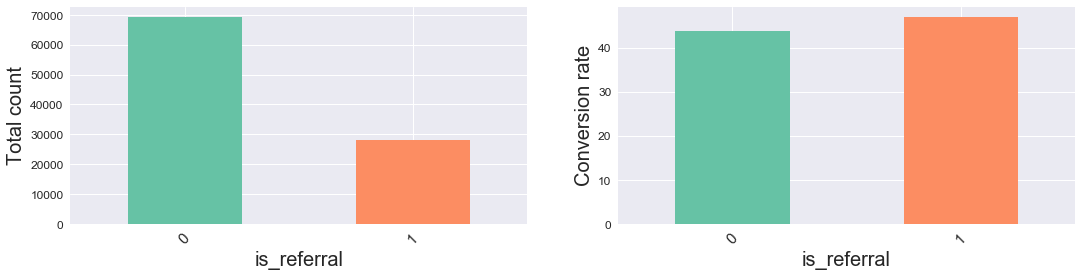

In [11]:
count_and_rate_plot(count_and_rate(referral, 'is_referral', 'money_spent'))

### Less transactions are through referral, but average transaction amount from referral is higher.